# Vision Transformer - MNIST

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
def create_patches(inputs, patch_size, num_patches, projection_dim, return_patches=False):
    patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    reshaped_patches = layers.Reshape((num_patches, projection_dim))(patches)
    if return_patches:
        return patches  # Return patches for visualization
    return reshaped_patches

def add_position_embedding(patches, num_patches, projection_dim):
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)(tf.range(num_patches))
    return patches + position_embedding

In [3]:
def transformer_encoder(patches, projection_dim, num_heads, transformer_depth):
    for _ in range(transformer_depth):
        # Normalize the input patches
        x1 = layers.LayerNormalization(epsilon=1e-6)(patches)
        
        # Apply Multi-Head Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        
        # Add the attention output back to the input (Skip Connection)
        x2 = layers.Add()([attention_output, patches])
        
        # Normalize the result of the addition
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Apply a feed-forward network (FFN) within the transformer, first expanding then projecting back
        x3 = layers.Dense(units=projection_dim*2, activation="relu")(x3)
        patches = layers.Dense(units=projection_dim)(x3)
        
        # Add the output of the FFN back to the combined result of the attention output and the input (Second Skip Connection)
        patches = layers.Add()([patches, x2])
        
    return patches

def build_classifier(patches, num_classes):
    # Normalize the input
    representation = layers.LayerNormalization(epsilon=1e-6)(patches)
    
    # Flatten the normalized tensor to prepare for the dense layer
    representation = layers.Flatten()(representation)
    
    # Dropout for regularization
    features = layers.Dropout(0.5)(representation)
    
    # Dense layer for learning non-linear combinations
    features = layers.Dense(128, activation="relu")(features)
    
    # Another dropout for regularization
    features = layers.Dropout(0.5)(features)
    
    # Final dense layer with softmax activation for classification
    outputs = layers.Dense(num_classes, activation="softmax")(features)
    
    return outputs

def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_depth, num_classes):
    # Define the input layer with the specified input shape
    inputs = layers.Input(shape=input_shape)
    
    # Extract patches from the input image and project to a higher-dimensional space
    patches = create_patches(inputs, patch_size, num_patches, projection_dim)
    
    # Add positional embeddings to the patches to retain positional information
    patches = add_position_embedding(patches, num_patches, projection_dim)
    
    # Pass the patches through the transformer encoder to process interactions between patches
    patches = transformer_encoder(patches, projection_dim, num_heads, transformer_depth)
    
    # Build the classifier head to make final predictions from the encoded features
    outputs = build_classifier(patches, num_classes)
    
    # Create the final Keras model with inputs as the image and outputs as the class predictions
    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [4]:
#Plot the accuracy 
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## Dataset

In [5]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1)  # Expanding to (28, 28, 1)
x_test = np.expand_dims(x_test, -1)    # Same for test set
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Model

In [6]:
# Model configuration
input_shape = (28, 28, 1)  # MNIST images size
patch_size = 4  # Patch size: 4x4
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
num_heads = 4
transformer_depth = 4
num_classes = 10  # 10 classes for the digits 0-9

In [7]:
model = create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_depth, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 7, 7, 64)             1088      ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 49, 64)               0         ['conv2d[0][0]']              
                                                                                                  
 tf.math.add (TFOpLambda)    (None, 49, 64)               0         ['reshape[0][0]']             
                                                                                              

In [8]:
optimizer = Adam(learning_rate=0.01) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate the model
model.evaluate(x_test, y_test)

Epoch 1/5
1688/1688 [==============================] - 125s 73ms/step - loss: 2.3630 - accuracy: 0.1096 - val_loss: 2.3023 - val_accuracy: 0.1050
Epoch 2/5
1688/1688 [==============================] - 161s 95ms/step - loss: 2.3028 - accuracy: 0.1102 - val_loss: 2.3038 - val_accuracy: 0.0952
Epoch 3/5
1688/1688 [==============================] - 169s 100ms/step - loss: 2.3023 - accuracy: 0.1101 - val_loss: 2.3023 - val_accuracy: 0.1113
Epoch 4/5
1688/1688 [==============================] - 164s 97ms/step - loss: 2.3024 - accuracy: 0.1109 - val_loss: 2.3019 - val_accuracy: 0.1050
Epoch 5/5
313/313 [==============================] - 15s 46ms/step - loss: 2.3028 - accuracy: 0.1135


[2.3027961254119873, 0.11349999904632568]

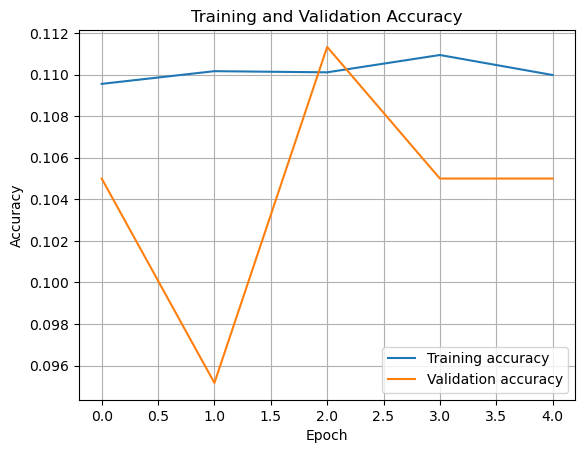

In [10]:
# Call the function to plot the accuracy
plot_accuracy(history)